# Preprocesarea datelor
In prima parte a proiectului incarcam imaginile si formam tabelul cu caracteristici folosit ulterior pentru restul cerintelor.

In [16]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
from PIL import Image
from skimage.filters import threshold_otsu
from scipy.stats import skew
from skimage.feature import graycomatrix, graycoprops

# functie pentru convertirea imaginii in numpy array
def preprocess_image_pil(image_path, target_size):
    img = Image.open(image_path)
    img_gray = img.convert('L') # convertim in imagine gray-scale
    img_resized_pil = img_gray.resize(target_size)  # redimensionam toate imaginile la 256x256
    img_array = np.array(img_resized_pil)  # convertim intr-un array numpy
    return img_array

# functie pentru extragerea caracteristicilor
def extract_image_features(image_gray):
    features = {}
    flat_pixels = image_gray.flatten()
    # incercam cat pe mult sa ignoram background-ul negru
    # care strica valorile caracteristicilor folosind threshold_otsu
    uniq_vals = np.unique(image_gray)
    thresh = threshold_otsu(image_gray)
    brain_pixels = flat_pixels[flat_pixels > thresh]
    brain_pixels_normalized = brain_pixels / 255.0 # normalizam valorile pixelilor
    features['mean_intensity'] = np.mean(brain_pixels_normalized)
    features['std_intensity'] = np.std(brain_pixels_normalized)
    features['skewness'] = skew(brain_pixels_normalized)
    features['max_intensity'] = np.max(brain_pixels_normalized)
    # gray level co-occurance matrix - ne ajuta sa calculam caracteristici mai avansate
    # despre pixelii pe care ii avem in poza
    glcm = graycomatrix(image_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    features['contrast'] = graycoprops(glcm, 'contrast')[0, 0]
    features['energy'] = graycoprops(glcm, 'energy')[0, 0]
    features['homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
    features['dissimilarity'] = graycoprops(glcm, 'dissimilarity')[0, 0]
    features['correlation'] = graycoprops(glcm, 'correlation')[0, 0]
    glcm = glcm[glcm > 0] # avem grija sa nu calculam log(0)
    features['entropy'] = -np.sum(glcm * np.log2(glcm))
    return features

directory = '/content/drive/My Drive/All_Tumor_Labeled'
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
img_size = (256, 256)
output_csv = 'brain_tumor_features.csv'
all_features_list = []
print(f"Inceput extragere caracteristici...")
# iteram prin toate tipurile de tumori
for category_idx, category in enumerate(categories):
    category_path = os.path.join(directory, category)
    print(f"Procesare categorie: {category}...")
    # luam imaginile din tipul 'category' de tumori
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith('.jpg')]
    # iteram prin fiecare imagine
    for i, image_name in enumerate(image_files):
        image_path = os.path.join(category_path, image_name)
        # transforma imaginea intr-un numpy array ca sa putem lucra cu array-ul creat
        preprocessed_img_array = preprocess_image_pil(image_path, img_size)
        # extrage caracteristicile din array-ul creat
        img_features = extract_image_features(preprocessed_img_array)
        # adaugam tipul tumorii printre caracteristici
        img_features['tumor_type'] = category
        # punem toate caracteristicile in lista
        all_features_list.append(img_features)
        # afisam la fiecare 200 de iteratii sa putem vedea progresul
        if (i + 1) % 200 == 0:
            print(f"  Procesat {i + 1}/{len(image_files)} imagini in {category}...")
    print(f"Finalizat procesarea a {len(image_files)} imagini pentru categoria: {category}.")
features_df = pd.DataFrame(all_features_list)
# odata terminat afisam un mesaj de finalizare extragere
# si afisam primele 5 randuri + caracteristicile dataframe-ului
print(f"Extragerea caracteristicilor a {len(all_features_list)} finalizata.")
print(features_df.head())
print("Informatii DataFrame:")
features_df.info()
# salvam datele intr-un csv
features_df.to_csv(output_csv, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Inceput extragere caracteristici...
Procesare categorie: glioma...
  Procesat 200/1621 imagini in glioma...
  Procesat 400/1621 imagini in glioma...
  Procesat 600/1621 imagini in glioma...
  Procesat 800/1621 imagini in glioma...
  Procesat 1000/1621 imagini in glioma...
  Procesat 1200/1621 imagini in glioma...
  Procesat 1400/1621 imagini in glioma...
  Procesat 1600/1621 imagini in glioma...
Finalizat procesarea a 1621 imagini pentru categoria: glioma.
Procesare categorie: meningioma...
  Procesat 200/1645 imagini in meningioma...
  Procesat 400/1645 imagini in meningioma...
  Procesat 600/1645 imagini in meningioma...
  Procesat 800/1645 imagini in meningioma...
  Procesat 1000/1645 imagini in meningioma...
  Procesat 1200/1645 imagini in meningioma...
  Procesat 1400/1645 imagini in meningioma...
  Procesat 1600/1645 imagini in meningioma...
Finalizat p

# Data split
Functia care ne imparte datele in 80% antrenament si 20% test avand grija ca cele doua sa fie uniform impartite.

In [17]:
from sklearn.model_selection import train_test_split
import pandas as pd

tumor_features = pd.read_csv("brain_tumor_features.csv")
y = tumor_features['tumor_type']
X = tumor_features.drop(columns=['tumor_type'])
# y reprezinta label-ul tumorilor; X reprezinta caracteristicile
# le dam shuffle si le impartim in 80% train - 20% test.
# stratify ne ajuta sa mentinem o impartire uniforma
# sa nu avem 80% din clasa notumor intr-o parte de exemplu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
# salvam fisierele train.csv si test.csv cu datele pe care se va antrena modelul
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

# Analiza Datelor

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

features = ['mean_intensity', 'std_intensity', 'skewness', 'max_intensity', 'contrast', 'energy', 'homogeneity', 'dissimilarity', 'correlation', 'entropy']
target_column = 'tumor_type'
plots_dir = "eda_plots"

print("Statistici descriptive pentru caracteristici (Date de Antrenament):")
print(train_df[features].describe())

print("Statistici descriptive pentru caracteristici (Date de Test):")
print(test_df[features].describe())

print(f"Statistici descriptive pentru target '{target_column}' (Date de Antrenament):")
print(train_df[target_column].describe())

print(f"Statistici descriptive pentru target '{target_column}' (Date de Test):")
print(test_df[target_column].describe())

Statistici descriptive pentru caracteristici (Date de Antrenament):
       mean_intensity  std_intensity     skewness  max_intensity     contrast  \
count     5618.000000    5618.000000  5618.000000    5618.000000  5618.000000   
mean         0.379101       0.125424     1.549290       0.965052   226.740548   
std          0.121961       0.030770     0.689165       0.044838   310.658456   
min          0.153060       0.049770    -3.374000       0.498039    15.975980   
25%          0.306059       0.106555     1.264616       0.949020   108.693842   
50%          0.341504       0.120255     1.630129       0.976471   142.920190   
75%          0.410746       0.136483     1.970078       1.000000   201.060578   
max          0.954476       0.250973     3.574126       1.000000  3332.470190   

            energy  homogeneity  dissimilarity  correlation      entropy  
count  5618.000000  5618.000000    5618.000000  5618.000000  5618.000000  
mean      0.201604     0.459632       6.346954     0

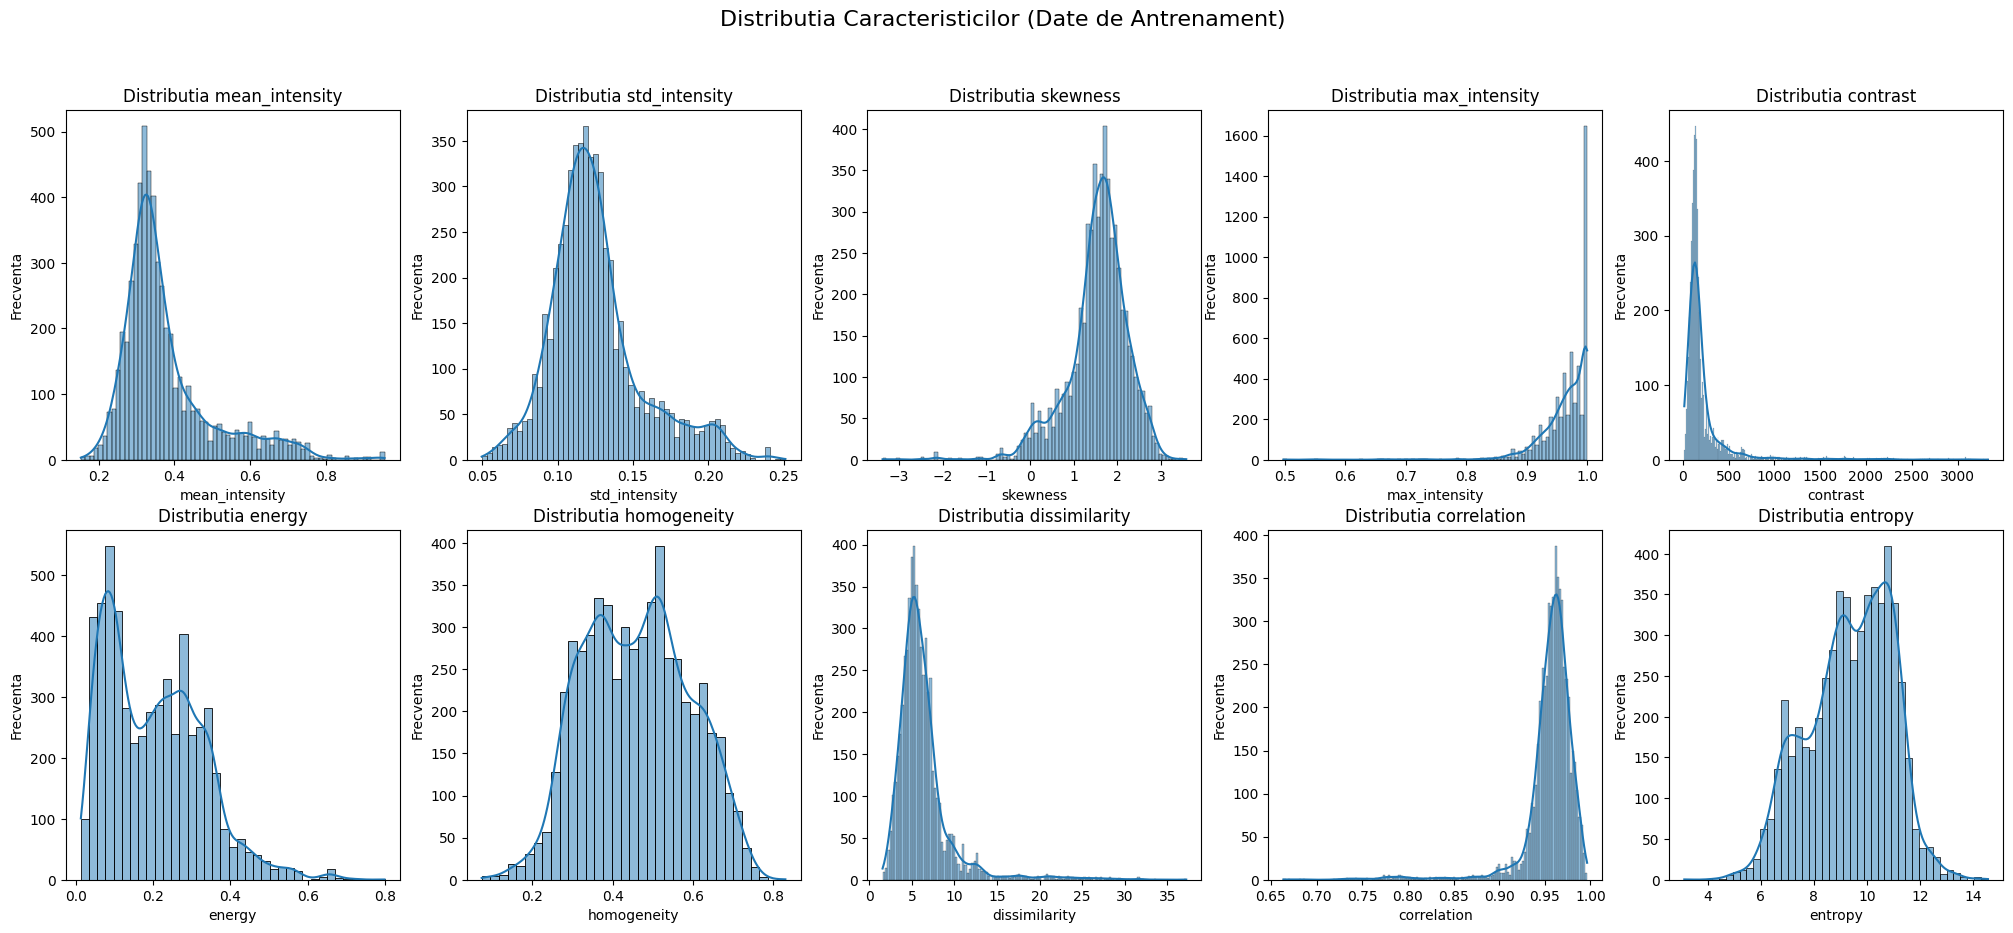

In [19]:
# histograme pentru caracteristici pe datele de antrenament
fig_train, axes_train = plt.subplots(2, 5, figsize=(25, 10))
fig_train.suptitle('Distributia Caracteristicilor (Date de Antrenament)', fontsize=16)
axes_train = axes_train.flatten()
for i, feature in enumerate(features):
    sns.histplot(train_df[feature], kde=True, ax=axes_train[i])
    axes_train[i].set_title(f'Distributia {feature}', fontsize=12)
    axes_train[i].set_xlabel(feature, fontsize=10)
    axes_train[i].set_ylabel('Frecventa', fontsize=10)

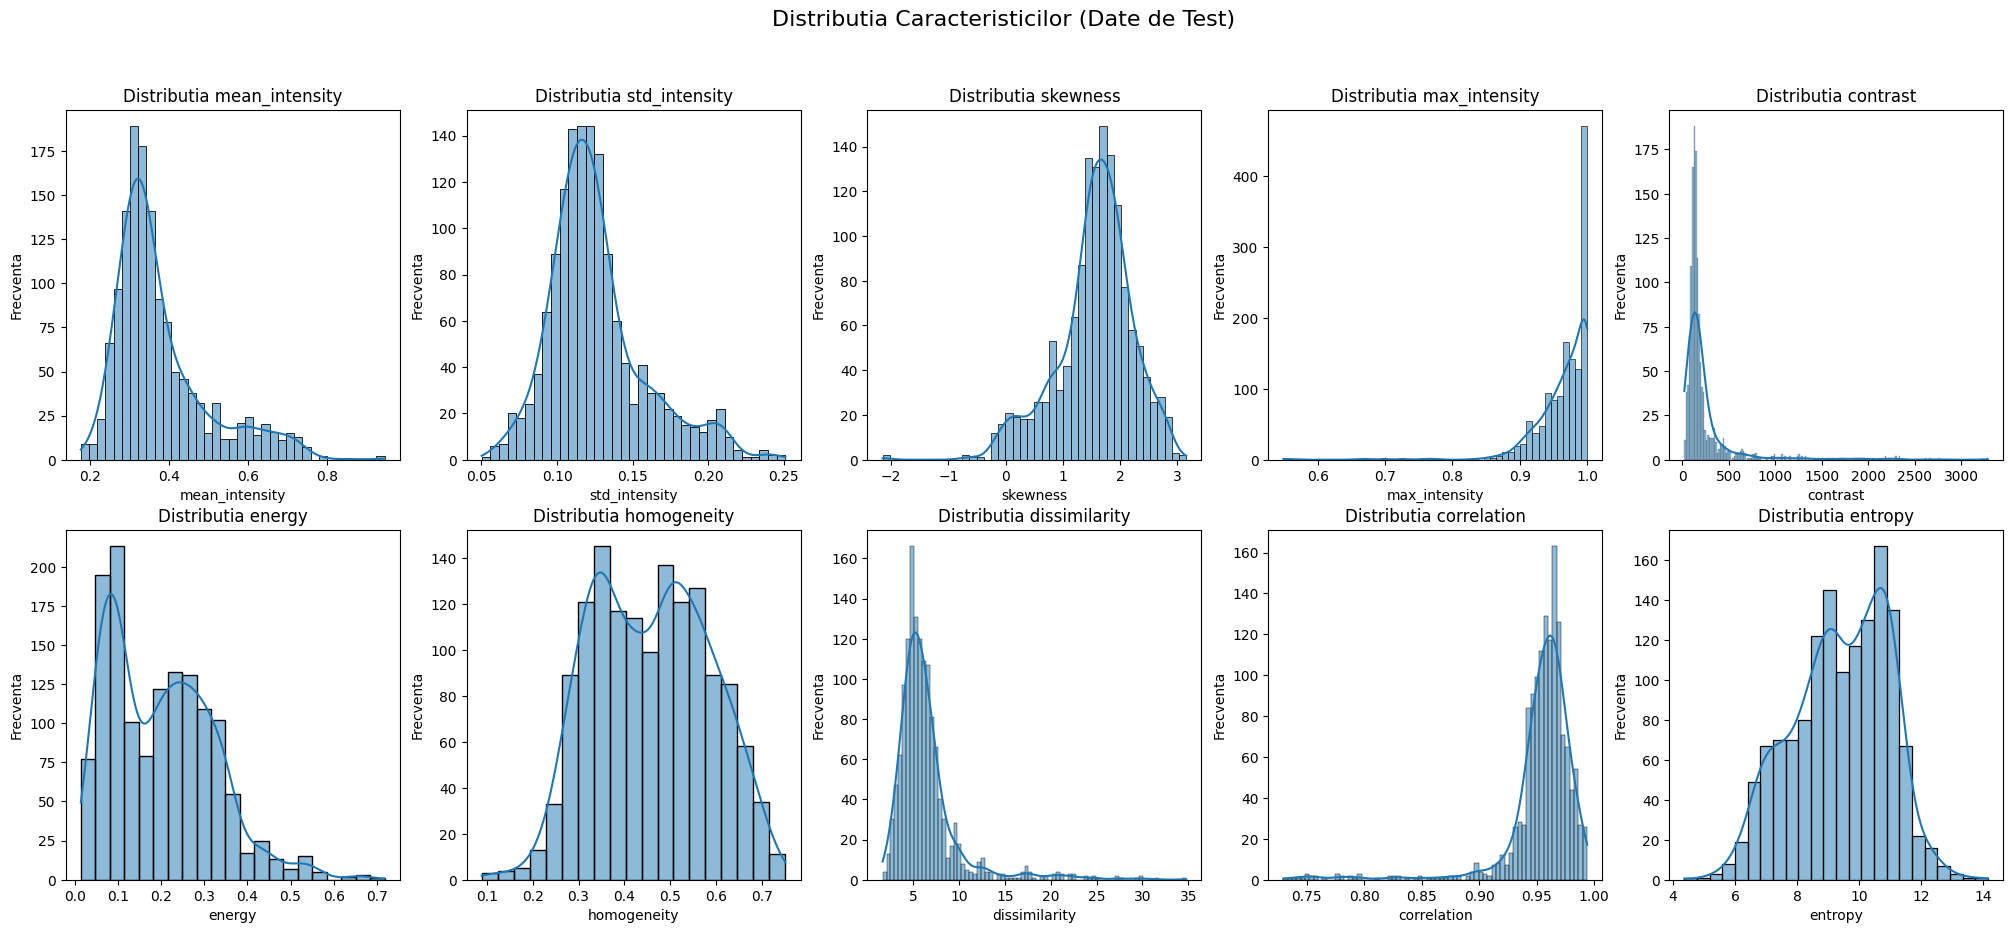

In [20]:
# histograme pentru date de test
fig_test, axes_test = plt.subplots(2, 5, figsize=(25, 10))
fig_test.suptitle('Distributia Caracteristicilor (Date de Test)', fontsize=16)
axes_test = axes_test.flatten()
for i, feature in enumerate(features):
    sns.histplot(test_df[feature], kde=True, ax=axes_test[i])
    axes_test[i].set_title(f'Distributia {feature}', fontsize=12)
    axes_test[i].set_xlabel(feature, fontsize=10)
    axes_test[i].set_ylabel('Frecventa', fontsize=10)

Text(0, 0.5, 'Numar')

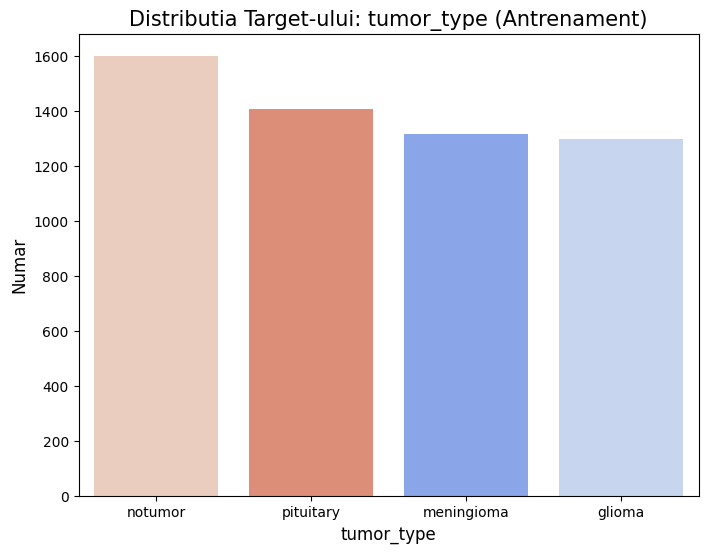

In [21]:
# countplots pentru target in datele de antrenament
fig_countplot_train, ax_countplot_train = plt.subplots(figsize=(8, 6))
sns.countplot(data=train_df, x=target_column, ax=ax_countplot_train, order=train_df[target_column].value_counts().index, hue=target_column, palette="coolwarm", legend=False)
ax_countplot_train.set_title(f'Distributia Target-ului: {target_column} (Antrenament)', fontsize=15)
ax_countplot_train.set_xlabel(target_column, fontsize=12)
ax_countplot_train.set_ylabel('Numar', fontsize=12)

Text(0, 0.5, 'Numar')

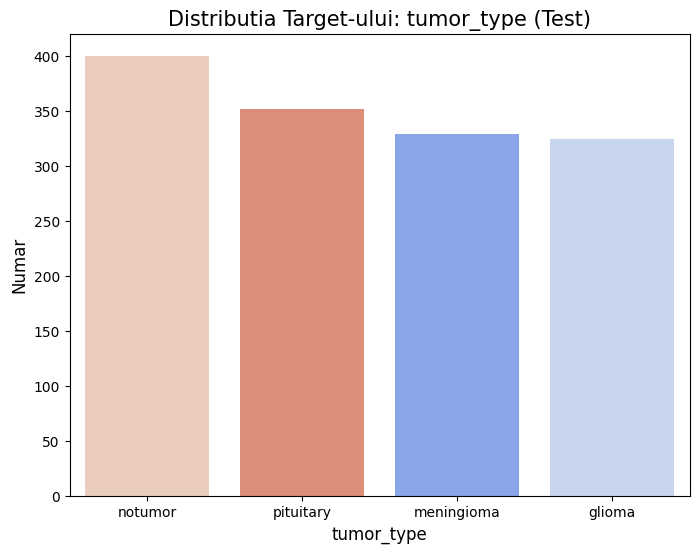

In [22]:
# countplots pentru target in datele de test
fig_countplot_test, ax_countplot_test = plt.subplots(figsize=(8, 6))
sns.countplot(data=test_df, x=target_column, ax=ax_countplot_test, order=test_df[target_column].value_counts().index, hue=target_column, palette="coolwarm", legend=False)
ax_countplot_test.set_title(f'Distributia Target-ului: {target_column} (Test)', fontsize=15)
ax_countplot_test.set_xlabel(target_column, fontsize=12)
ax_countplot_test.set_ylabel('Numar', fontsize=12)

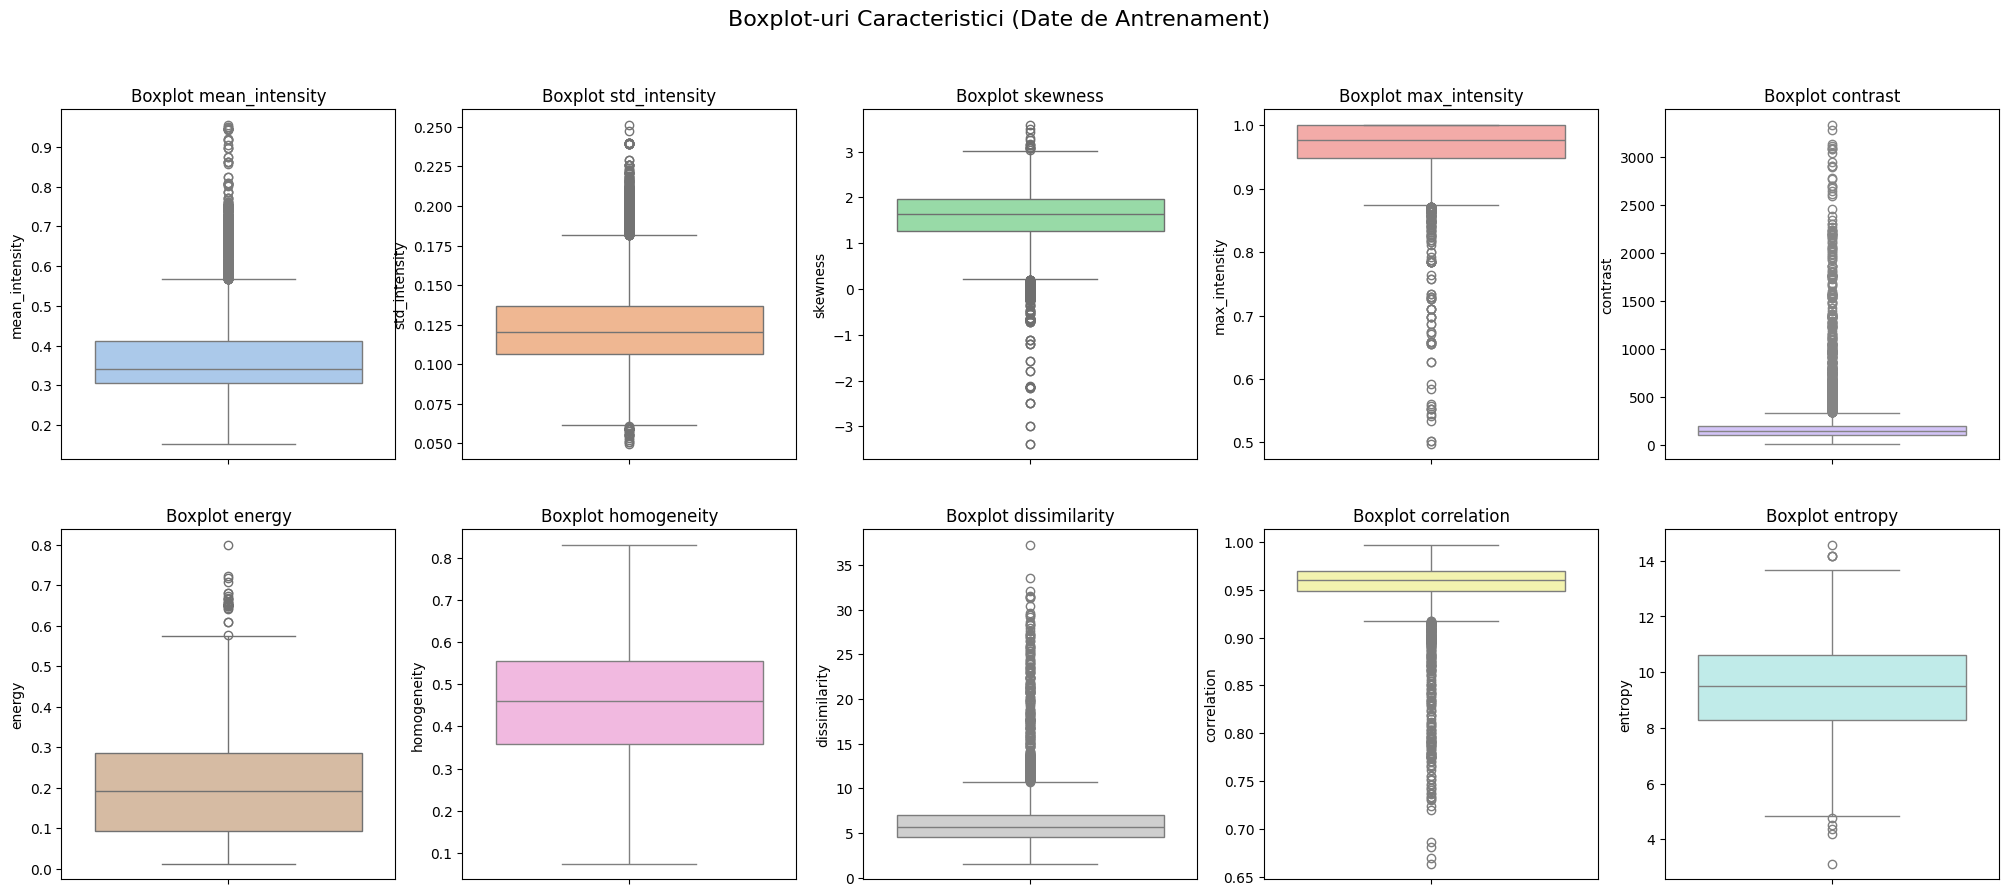

In [28]:
# boxplot-uri pentru date de antrenament
fig_boxplot_train, axes_boxplot_train = plt.subplots(2, 5, figsize=(25, 10))
fig_boxplot_train.suptitle('Boxplot-uri Caracteristici (Date de Antrenament)', fontsize=16)
axes_boxplot_train = axes_boxplot_train.flatten()
pastel_colors = sns.color_palette("pastel")
for i, feature in enumerate(features):
    sns.boxplot(data=train_df, y=feature, ax=axes_boxplot_train[i], color=pastel_colors[i % len(pastel_colors)])
    axes_boxplot_train[i].set_title(f'Boxplot {feature}', fontsize=12)
    axes_boxplot_train[i].set_ylabel(feature, fontsize=10)

Text(0.5, 1.0, 'Matrice de Corelatie a Caracteristicilor (Antrenament)')

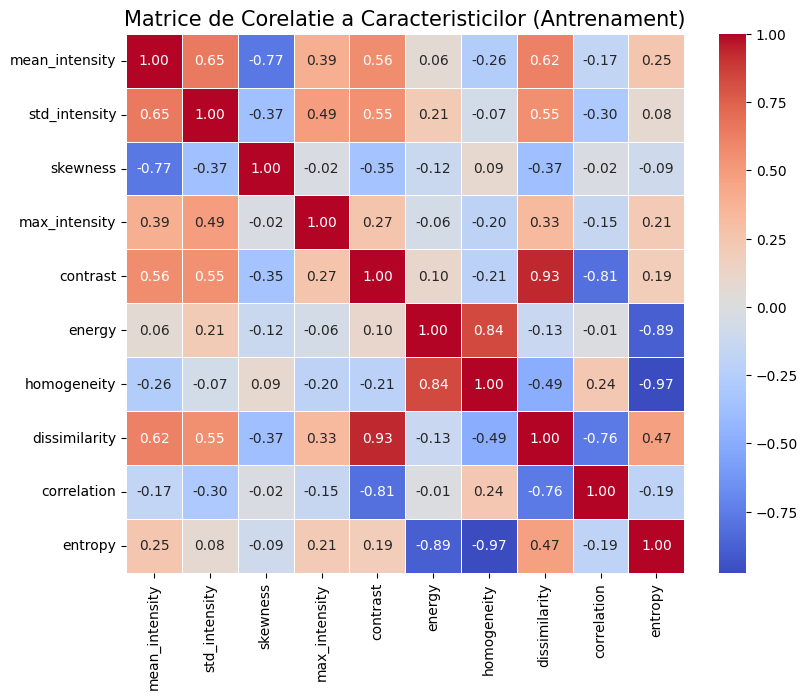

In [26]:
# matricea de corelatie intre caracteristici
correlation_matrix_train = train_df[features].corr()
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(correlation_matrix_train, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax)
ax.set_title('Matrice de Corelatie a Caracteristicilor (Antrenament)', fontsize=15)

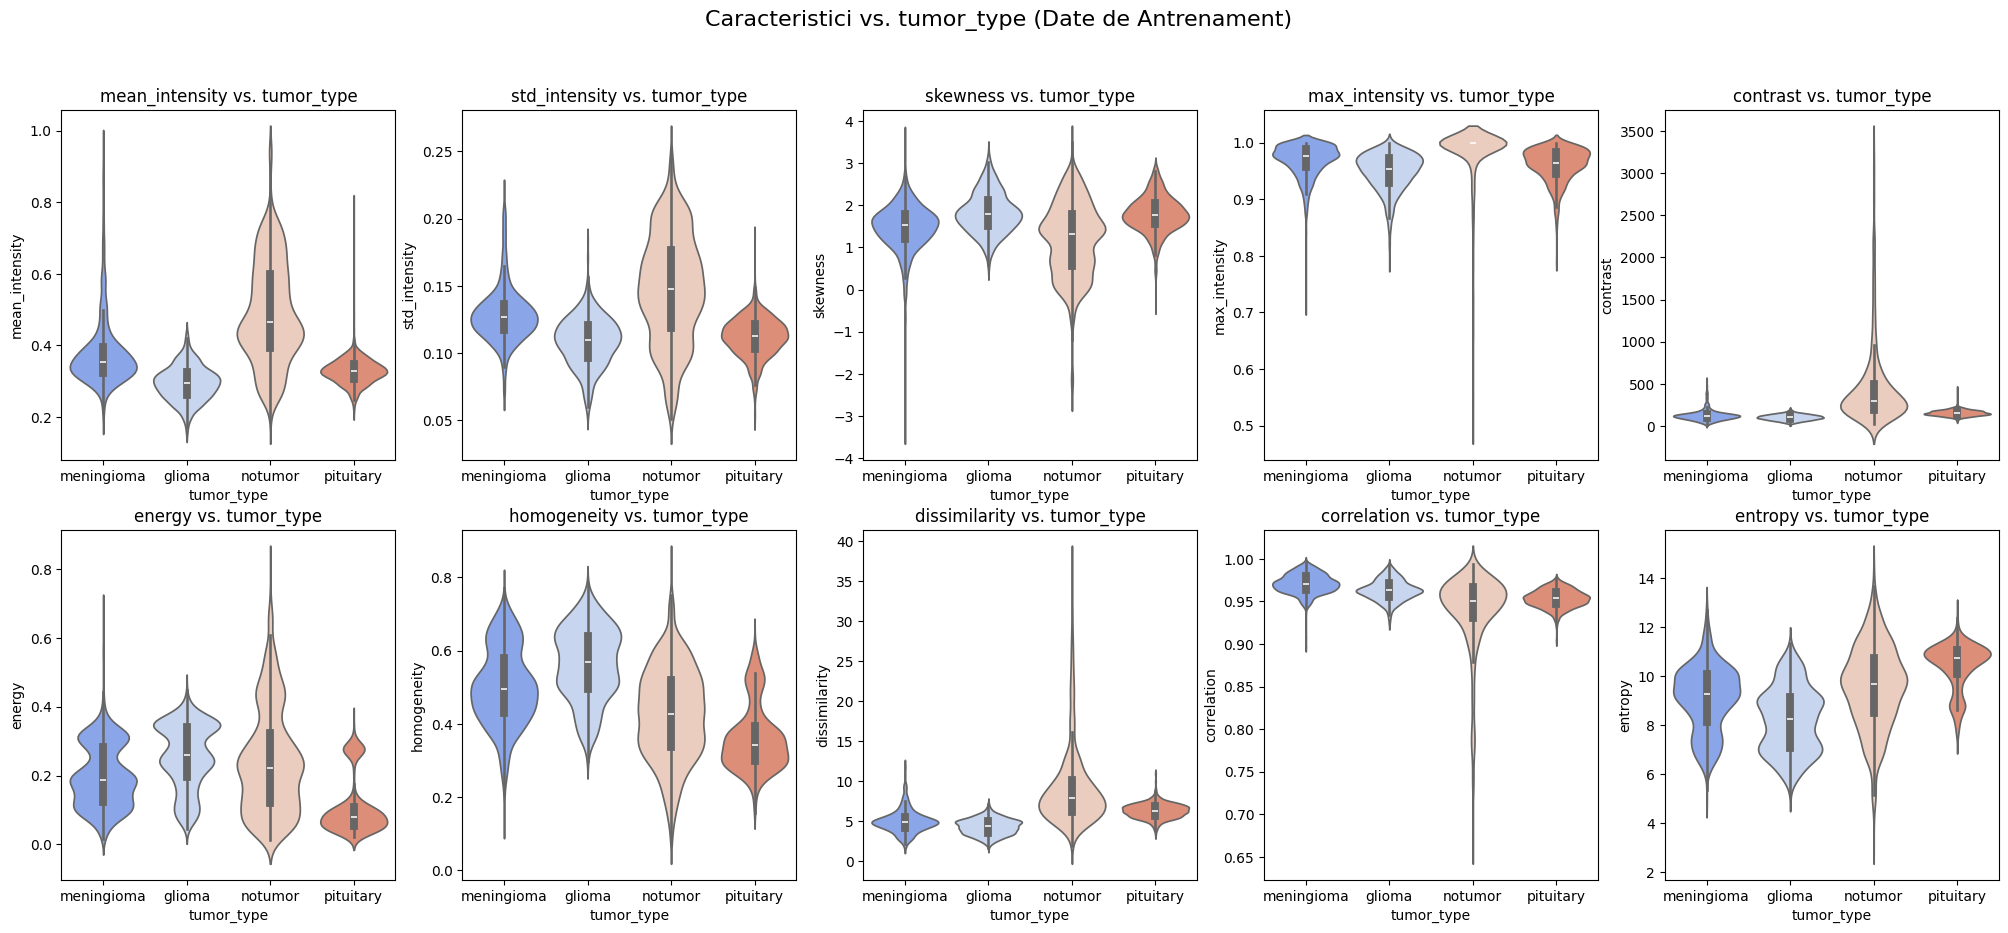

In [29]:
# violin plot-uri pentru caracteristiciile din datele de antrenament vs target
fig_violin_train, axes_violin_train = plt.subplots(2, 5, figsize=(25, 10))
fig_violin_train.suptitle(f'Caracteristici vs. {target_column} (Date de Antrenament)', fontsize=16)
axes_violin_train = axes_violin_train.flatten()
for i, feature in enumerate(features):
    sns.violinplot(x=target_column, y=feature, data=train_df, ax=axes_violin_train[i], hue=target_column, palette="coolwarm", legend=False)
    axes_violin_train[i].set_title(f'{feature} vs. {target_column}', fontsize=12)
    axes_violin_train[i].set_xlabel(target_column, fontsize=10)
    axes_violin_train[i].set_ylabel(feature, fontsize=10)